[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yokolet/DeepLearning/blob/master/dcgan/DCGAN_by_PyTorch.ipynb)

# DCGAN by PyTorch

This is a Deep Convolutional Generative Adversarial Networks(DCGAN) using Street View House Numbers Dataset(SVHN).

The code is originally Udacity's Deep Learning tutorial, [dcgan-svhn](https://github.com/udacity/deep-learning/tree/master/dcgan-svhn). It is wriiten by TensorFlow. Recently, another major machine learning library, [PyTorch](https://pytorch.org/) drew people's attention. I'm among them. Out of my curiosity, I tried the same DCGAN by PyTorch. For this attempt, some parts of code were taken from PyTorch's [dcgan example](https://github.com/pytorch/examples/blob/master/dcgan/main.py).

The model is created following the [Original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf). The dataset is [the Street View House Numbers Dataset (SVHN)](http://ufldl.stanford.edu/housenumbers/), whose size is 32 x 32.

The notebook works on Google's colaboratory environment with setting of GPU for its runtime. The code includes PyTorch installation since PyTorch is not preinstalled on colaboratory at this moment.

## PyTorch Installation and import

For the first time importing torch without install PyTorch, the colaboratory provides the code block to install PyTorch. The provided code is set up to look at a specific website for the installation. This works, but simply calling pip install works as well like doing here.

In [2]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip3 install torch torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

## Other libraries

To show SVHN images, the cell below imports three libraries.

In [0]:
%matplotlib  inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

## Parameters

Below is definitions of various parameters.

In [4]:
dataroot = './data'    # path to dataset
batchSize = 128        # input batch size
workers = 2            # number of data loading workers
nz = 100               # size of a noise vector z
ngf = 64               # generator factor
ndf = 64               # discriminator factor
nc = 3                 # number of color channels
lr = 0.0002            # learning rate
alpha = 0.2            # leaky ReLU parameter
beta1 = 0.5            # Adam Optimizer parameter
niter = 25             # number of epochs

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Getting the dataset

The cell below downloads the SVHN dataset using torchvision. Also, dataloader are created using PyTorch's DataLoader.

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
trainset = torchvision.datasets.SVHN(root=dataroot, split='train',
                                     transform=transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                     ]),
                                     download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=workers)
testset = torchvision.datasets.SVHN(root=dataroot, split='test',
                                    transform=transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                     ]),
                                    download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=workers)

## Sample images

The SVHN files are .mat files typically used with Matlab. Those are loaded using scipy.io.loadmat which is imported above. Each image is 32 x 32 with 3 color channels (RGB). These are the real images to be passed to the discriminator. The generator is expected to create the same image eventually.

In [0]:
trainset = loadmat(dataroot + '/train_32x32.mat')
testset = loadmat(dataroot + '/test_32x32.mat')

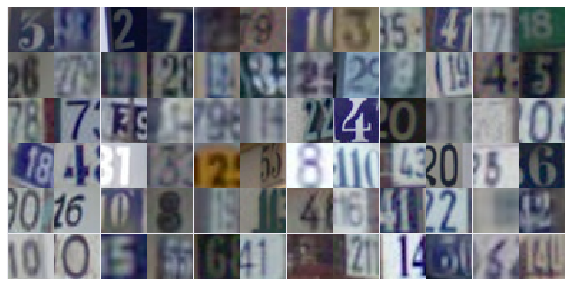

In [10]:
idx = np.random.randint(0, trainset['X'].shape[3], size=72)
fig, axes = plt.subplots(6, 12, sharex=True, sharey=True, figsize=(10,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

## Generator

The input will be a noise vector z. The output will be a 𝑡𝑎𝑛ℎ output with size of 32x32 which is the size of the SVHN images.

The generator will have convolutional layers to create new images. The first layer creates a deep and narrow layer, something like 4x4x512 as in the original DCGAN paper. In the layer, a batch normalization and a leaky ReLU activation will be used. following transposed convolution layers halve the depth and double the width and height of the previous layer. Again, the batch normalization and leaky ReLU come here.

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
      # input is Z, going into a convolution
      nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
      nn.BatchNorm2d(ngf * 8),
      nn.LeakyReLU(alpha, inplace=True),
      # state size. (ngf*8) x 4 x 4
      nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf * 4),
      nn.LeakyReLU(alpha, inplace=True),
      # state size. (ngf*4) x 8 x 8
      nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ngf * 2),
      nn.LeakyReLU(alpha, inplace=True),
      # state size. (ngf*2) x 16 x 16
      nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
      nn.Tanh()
      # state size. (nc) x 32 x 32
    )

  def forward(self, input):
    output = self.main(input)
    return output

## Discriminator

The discriminator is basically a convolutional classifier. The inputs to the discriminator are 32x32x3 tensors/images. The discriminator will have a few convolutional layers, then a fully connected layer for the output. At the last layer, an activation is sigmoid. 

> In the original DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
      # input is (nc) x 32 x 32
      nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
      nn.LeakyReLU(alpha, inplace=True),
      # state size. (ndf) x 16 x 16
      nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 2),
      nn.LeakyReLU(alpha, inplace=True),
      # state size. (ndf*2) x 8 x 8
      nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(ndf * 4),
      nn.LeakyReLU(alpha, inplace=True),
      # state size. (ndf*4) x 4 x 4
      nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
      nn.Sigmoid()
    )

  def forward(self, input):
    output = self.main(input)
    return output.view(-1, 1).squeeze(1)

## Initializes models, defines a loss function and optimizers

Here, the generator and discriminator models are initialized with weights. The loss function is BCELoss, which is Binary Cross Entropy. The BCELoss is a counterpart of TensorFlow's sigmoid_cross_entropy_with_logits. The optimizer is Adam Optimizer.

In [13]:
# custom weights initialization called on models
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.fill_(0)

g_model = Generator().to(device)
g_model.apply(weights_init)
print(g_model)

d_model = Discriminator().to(device)
d_model.apply(weights_init)
print(d_model)

# loss function
criterion = nn.BCELoss()

fixed_noise = torch.randn(batchSize, nz, 1, 1, device=device)
sample_noise = torch.randn(72, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

# setup optimizer
d_train_optim = optim.Adam(d_model.parameters(), lr=lr, betas=(beta1, 0.999))
g_train_optim = optim.Adam(g_model.parameters(), lr=lr, betas=(beta1, 0.999))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope

## Showing samples

The cell below defines a function to show samples. The function is called during the training and after the training.

In [0]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
  fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                           sharey=True, sharex=True)
  for ax, img in zip(axes.flatten(), samples[epoch]):
    img = np.rollaxis(img, 0, 3)
    ax.axis('off')
    img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
    ax.set_adjustable('box-forced')
    im = ax.imshow(img, aspect='equal')

  plt.subplots_adjust(wspace=0, hspace=0)
  return fig, axes

## Training

[0/25][0/573] Loss_D: 1.5560 Loss_G: 1.5158 D(x): 0.3416 D(G(z)): 0.2796 / 0.2502


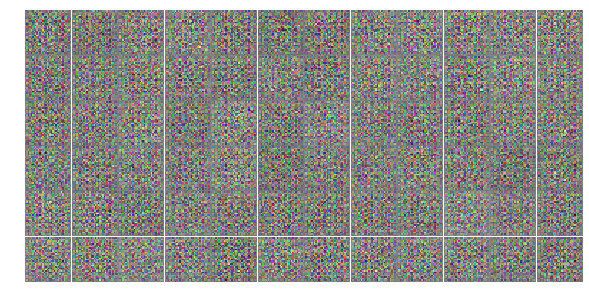

[1/25][0/573] Loss_D: 0.5681 Loss_G: 2.1727 D(x): 0.7376 D(G(z)): 0.1953 / 0.1428


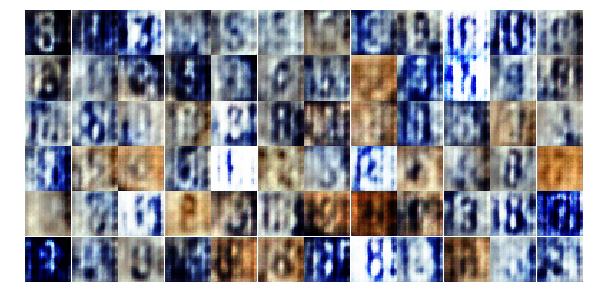

[2/25][0/573] Loss_D: 1.4588 Loss_G: 1.2915 D(x): 0.4736 D(G(z)): 0.4557 / 0.3171


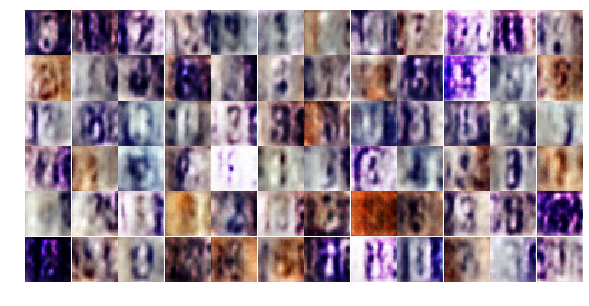

[3/25][0/573] Loss_D: 0.5883 Loss_G: 2.7698 D(x): 0.8246 D(G(z)): 0.2949 / 0.0790


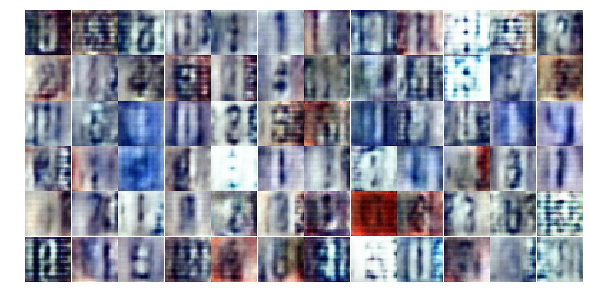

[4/25][0/573] Loss_D: 0.7395 Loss_G: 2.0064 D(x): 0.7826 D(G(z)): 0.3577 / 0.1604


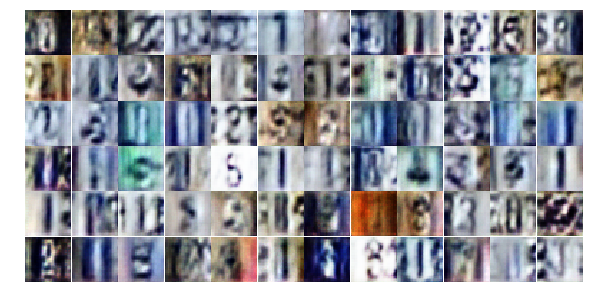

[5/25][0/573] Loss_D: 0.4724 Loss_G: 2.2251 D(x): 0.7944 D(G(z)): 0.1968 / 0.1406


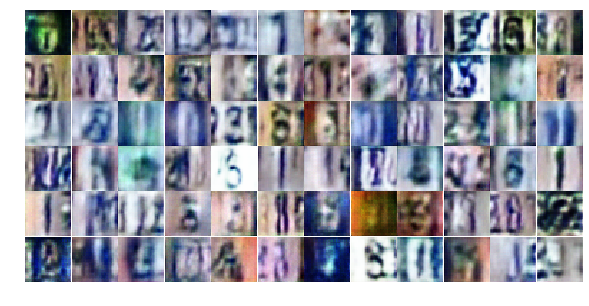

[6/25][0/573] Loss_D: 0.7245 Loss_G: 2.0792 D(x): 0.7365 D(G(z)): 0.3069 / 0.1516


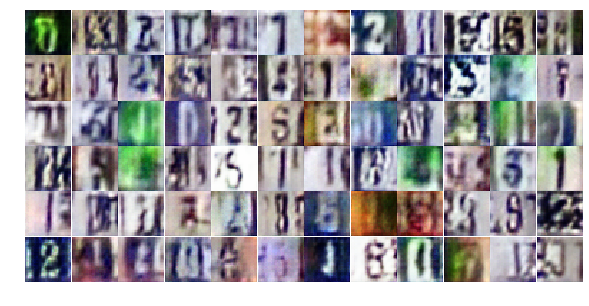

[7/25][0/573] Loss_D: 0.6714 Loss_G: 2.2006 D(x): 0.7449 D(G(z)): 0.2824 / 0.1457


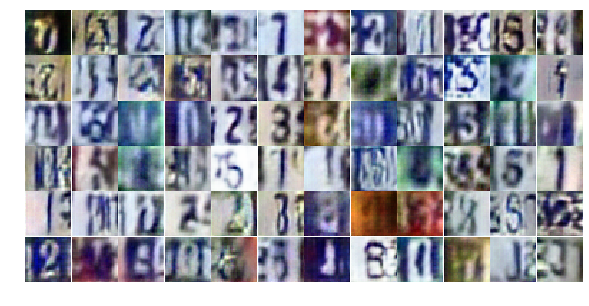

[8/25][0/573] Loss_D: 0.4302 Loss_G: 2.6327 D(x): 0.8558 D(G(z)): 0.2222 / 0.0951


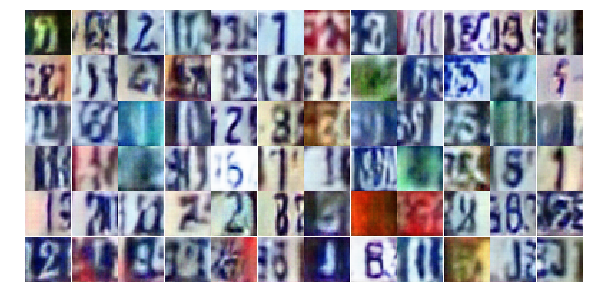

[9/25][0/573] Loss_D: 0.7013 Loss_G: 1.3404 D(x): 0.7004 D(G(z)): 0.2604 / 0.2944


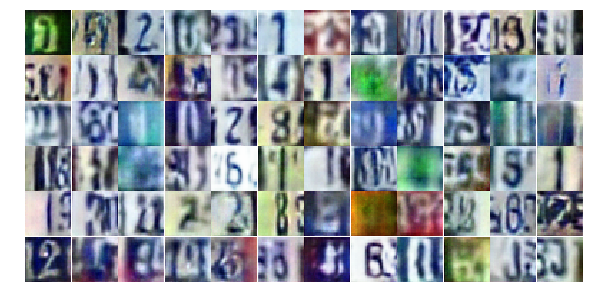

[10/25][0/573] Loss_D: 0.9383 Loss_G: 1.9835 D(x): 0.5913 D(G(z)): 0.2449 / 0.1825


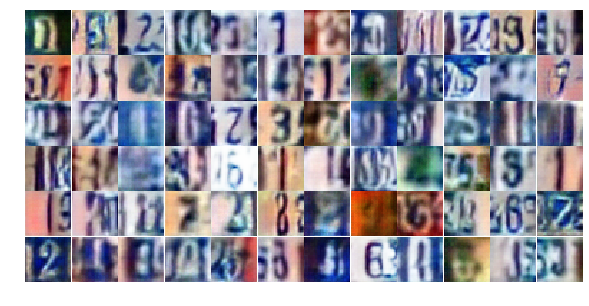

[11/25][0/573] Loss_D: 0.4128 Loss_G: 3.2527 D(x): 0.8920 D(G(z)): 0.2366 / 0.0561


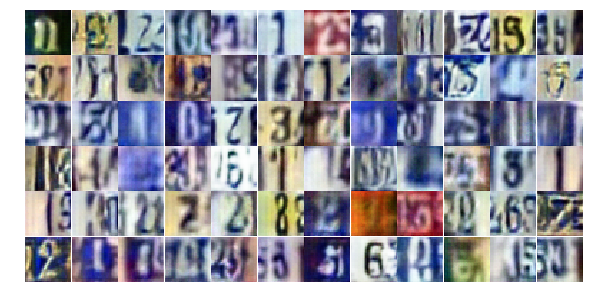

[12/25][0/573] Loss_D: 0.4662 Loss_G: 1.8424 D(x): 0.7813 D(G(z)): 0.1760 / 0.1893


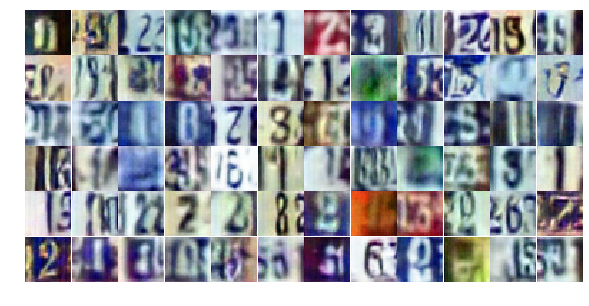

[13/25][0/573] Loss_D: 0.4284 Loss_G: 2.0715 D(x): 0.7650 D(G(z)): 0.1276 / 0.1619


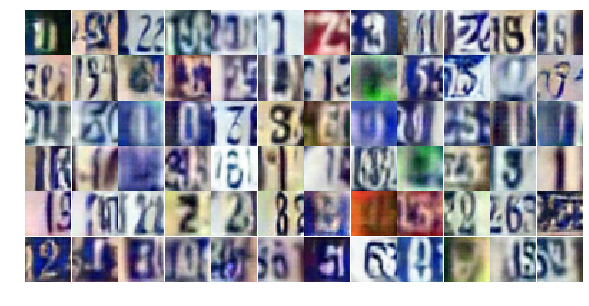

[14/25][0/573] Loss_D: 0.6487 Loss_G: 1.6632 D(x): 0.6349 D(G(z)): 0.1248 / 0.2726


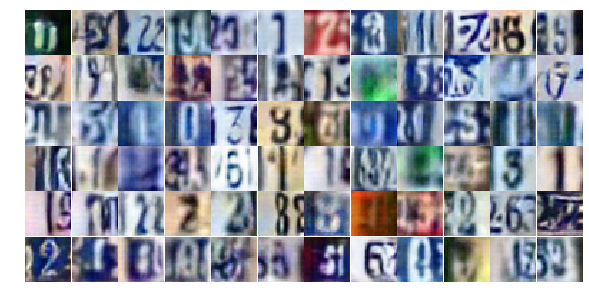

[15/25][0/573] Loss_D: 0.5428 Loss_G: 2.1797 D(x): 0.8357 D(G(z)): 0.2757 / 0.1468


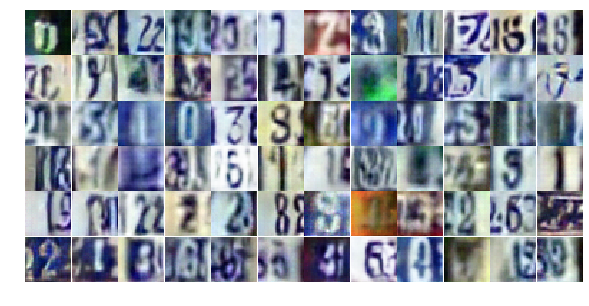

[16/25][0/573] Loss_D: 0.5856 Loss_G: 1.3139 D(x): 0.7584 D(G(z)): 0.2379 / 0.3164


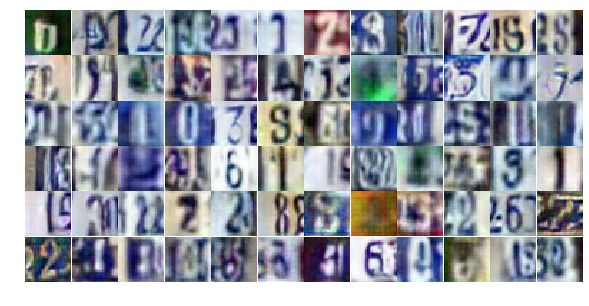

[17/25][0/573] Loss_D: 0.7090 Loss_G: 1.8465 D(x): 0.6369 D(G(z)): 0.1699 / 0.2110


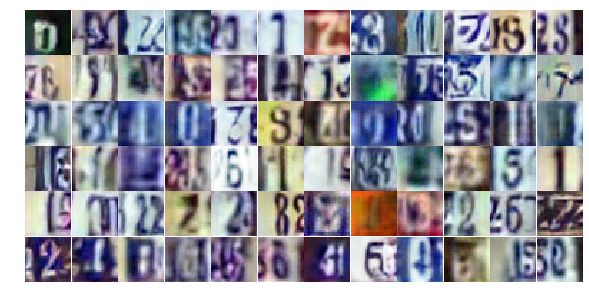

[18/25][0/573] Loss_D: 0.4342 Loss_G: 2.5906 D(x): 0.8861 D(G(z)): 0.2484 / 0.1050


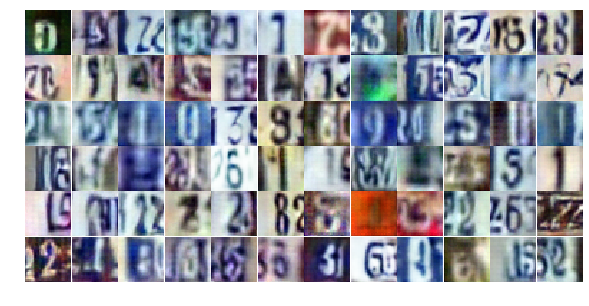

[19/25][0/573] Loss_D: 0.6333 Loss_G: 2.5262 D(x): 0.8346 D(G(z)): 0.3266 / 0.1037


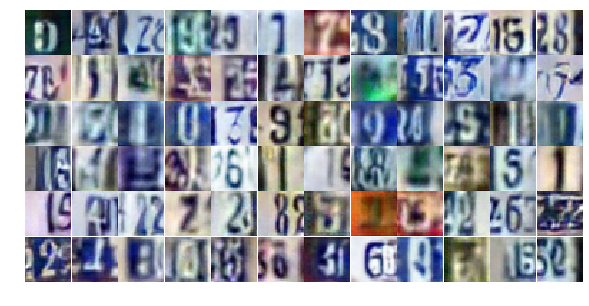

[20/25][0/573] Loss_D: 0.5014 Loss_G: 2.3749 D(x): 0.7042 D(G(z)): 0.1007 / 0.1252


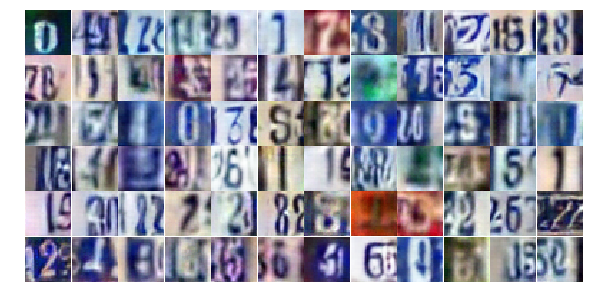

[21/25][0/573] Loss_D: 0.4289 Loss_G: 2.1606 D(x): 0.8066 D(G(z)): 0.1665 / 0.1728


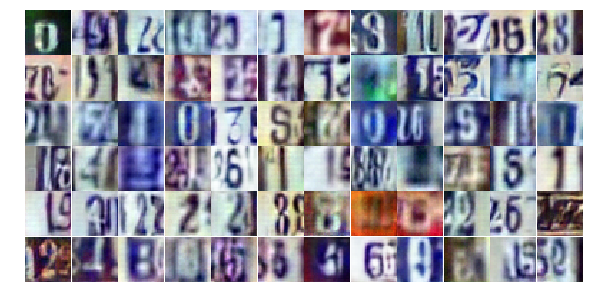

[22/25][0/573] Loss_D: 0.4660 Loss_G: 2.5462 D(x): 0.7772 D(G(z)): 0.1616 / 0.1132


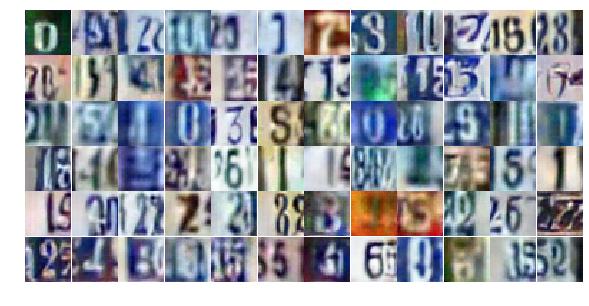

[23/25][0/573] Loss_D: 0.9742 Loss_G: 1.1845 D(x): 0.4498 D(G(z)): 0.0590 / 0.3781


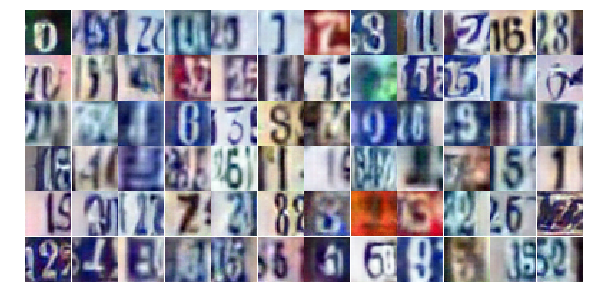

[24/25][0/573] Loss_D: 0.5769 Loss_G: 2.3088 D(x): 0.7256 D(G(z)): 0.1808 / 0.1523


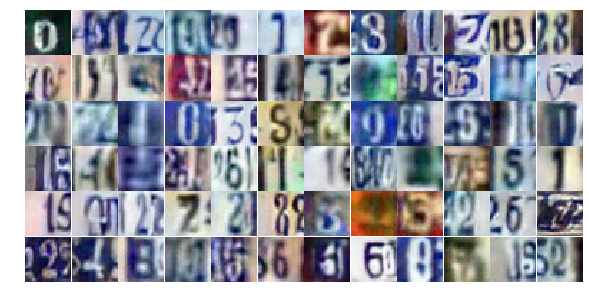

In [15]:
update_loss_every = 10
print_every=1000
show_every=1000
samples, losses = [], []

for epoch in range(niter):
  for i, data in enumerate(trainloader, 0):
    if data[0].size()[0] < batchSize:
      continue
    real_data = data[0].to(device)
    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    # train with real
    d_model.zero_grad()

    output = d_model(real_data)
    label = torch.full((batchSize,), real_label, device=device)

    d_loss_real = criterion(output, label)
    d_loss_real.backward()
    D_x = output.mean().item()

    # train with fake
    noise = torch.randn(batchSize, nz, 1, 1, device=device)
    fake = g_model(noise)
    label.fill_(fake_label)
    output = d_model(fake.detach())
    d_loss_fake = criterion(output, label)
    d_loss_fake.backward()
    D_G_z1 = output.mean().item()
    d_loss = d_loss_real + d_loss_fake
    d_train_optim.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    g_model.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    output = d_model(fake)
    g_loss = criterion(output, label)
    g_loss.backward()
    D_G_z2 = output.mean().item()
    g_train_optim.step()

    if i % update_loss_every == 0:
      losses.append((d_loss.item(), g_loss.item()))
    if i % print_every == 0:
      print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
            % (epoch, niter, i, len(trainloader),
               d_loss.item(), g_loss.item(), D_x, D_G_z1, D_G_z2))
    if i % show_every == 0:
      gen_samples = g_model(sample_noise).detach()
      sample = gen_samples.to(torch.device('cpu')).numpy()
      samples.append(sample)
      _ = view_samples(-1, samples, 6, 12, figsize=(10,5))
      plt.show()

## Sample images after the training

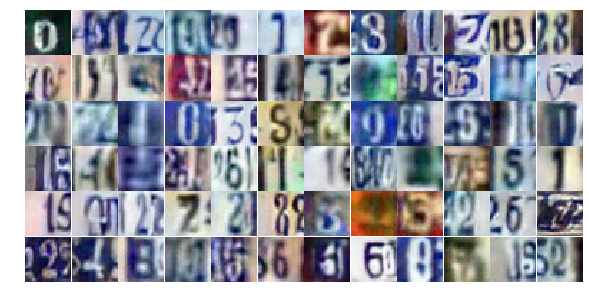

In [16]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

## Training Losses

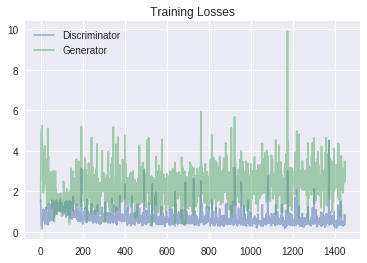

In [17]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()